In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import sqlalchemy as db
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import load_model as keras_load_model  # Rename the imported function
import matplotlib.pyplot as plt
from keras.initializers import GlorotUniform
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib

2024-02-12 21:35:02.070166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NEW CODE BELOW

In [2]:
# Load data
def load_data(file_path, symbol):
    # connect to the database
    engine = db.create_engine(f'sqlite:///{file_path}', echo=True)
    connection = engine.connect()

    # fetch the data
    query = "SELECT * FROM stocks WHERE symbol = '{}'".format(symbol)
    data = pd.read_sql(query, connection)

    return data

In [3]:

def preprocess_data(df):

    # Define the features and target variables
    target = ['TargetNextClose']
    symbol = df['symbol'].unique()[0] # Get the symbol name
    features = df.drop(['symbol', 'close', 'date', 'quarter', 'volume', 'daily_range', 'daily_return', 'high', 'low'], axis=1).columns.tolist() # list

    X = df[features].values
    y = df[target].values

    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = y_scaler.fit_transform(y)

    # Save the target variable scaler for this symbol
    y_scaler_filename = f"/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/scalers/{symbol}_y_scaler.save"
    joblib.dump(y_scaler, y_scaler_filename)

    # Apply scaling to the features 'X'
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = x_scaler.fit_transform(X)

    # Save the feature scaler for this symbol
    x_scaler_filename = f"/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/scalers/{symbol}_x_scaler.save"
    joblib.dump(x_scaler, x_scaler_filename)


    data_set_scaled = np.concatenate((X_scaled, y_scaled), axis=1)

    return X_scaled, y_scaled, data_set_scaled



def prepare_lstm_input(data_set_scaled, backcandles):
    # multiple feature from data provided to the model
    X = []

    print(data_set_scaled.shape[0])
    for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
        X.append([])
        for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
            X[j].append(data_set_scaled[i-backcandles:i, j])

    #move axis from 0 to position 2
    X=np.moveaxis(X, [0], [2])

    X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
    y=np.reshape(yi,(len(yi),1))

    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    return X, y

    

In [4]:

def plot(y_test, y_pred, symbol):
    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'black', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.legend()

    # save the plot
    output_file = f'/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/outputs/{symbol}_plot.png'
    plt.savefig(output_file)
    

In [5]:
data_file_path = '/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/data/atradebot.db'
symbol = 'AAPL'
data_frame = load_data(data_file_path, symbol).drop(['id'], axis=1)
data_frame

2024-02-12 21:35:04,969 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-02-12 21:35:04,969 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM stocks WHERE symbol = 'AAPL'")
2024-02-12 21:35:04,970 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-12 21:35:04,971 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM stocks WHERE symbol = 'AAPL'")
2024-02-12 21:35:04,971 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-12 21:35:04,972 INFO sqlalchemy.engine.Engine SELECT * FROM stocks WHERE symbol = 'AAPL'
2024-02-12 21:35:04,973 INFO sqlalchemy.engine.Engine [raw sql] ()


,symbol,date,close,adj_close,volume,open,high,low,daily_return,daily_range,quarter,EMA_Close_5,EMA_Close_20,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,AAPL,2020-01-02,75.087502,73.059410,135480400,74.059998,75.150002,73.797501,0.000000,1.352501,2020Q1,75.087502,75.087502,NaN,NaN,NaN,NaN,72.349136
1,AAPL,2020-01-03,74.357498,72.349136,146322800,74.287498,75.144997,74.125000,-0.009722,1.019997,2020Q1,74.649500,74.704250,NaN,NaN,NaN,NaN,72.925629
2,AAPL,2020-01-06,74.949997,72.925629,118387200,73.447502,74.989998,73.187500,0.007968,1.802498,2020Q1,74.791840,74.794487,NaN,NaN,NaN,NaN,72.582657
3,AAPL,2020-01-07,74.597504,72.582657,108872000,74.959999,75.224998,74.370003,-0.004703,0.854996,2020Q1,74.711116,74.737621,NaN,NaN,NaN,NaN,73.750244
4,AAPL,2020-01-08,75.797501,73.750244,132079200,74.290001,76.110001,74.290001,0.016086,1.820000,2020Q1,75.128164,74.993997,NaN,NaN,NaN,NaN,75.316765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,AAPL,2024-02-05,187.679993,187.440811,69668800,188.149994,189.250000,185.839996,0.009847,3.410004,2024Q1,187.483832,188.886653,47.475679,188.886653,185.894673,183.028363,189.058762
1030,AAPL,2024-02-06,189.300003,189.058762,43490800,186.860001,189.309998,186.770004,0.008632,2.539993,2024Q1,188.089222,188.926020,50.554019,188.926020,185.962105,183.111431,189.168625
1031,AAPL,2024-02-07,189.410004,189.168625,53439000,190.639999,191.050003,188.610001,0.000581,2.440002,2024Q1,188.529483,188.972114,50.763951,188.972114,186.030380,183.194856,188.080017
1032,AAPL,2024-02-08,188.320007,188.080017,40962000,189.389999,189.539993,187.350006,-0.005755,2.189987,2024Q1,188.459658,188.910008,48.574428,188.910008,186.075719,183.262739,188.850006


In [6]:
# for column RSI, fill the NaN values with that column's mean
data_frame['RSI'] = data_frame['RSI'].fillna(data_frame['RSI'].mean())

# for column EMAF, fill the NaN values with that column's mean
data_frame['EMAF'] = data_frame['EMAF'].fillna(data_frame['EMAF'].mean())

# for column EMAM, fill the NaN values with that column's mean
data_frame['EMAM'] = data_frame['EMAM'].fillna(data_frame['EMAM'].mean())

# for column EMAS, fill the NaN values with that column's mean
data_frame['EMAS'] = data_frame['EMAS'].fillna(data_frame['EMAS'].mean())



In [7]:

symbol = data_frame['symbol'].unique()[0]
# Preprocess the data
data_set_scaled, features, target = preprocess_data(data_frame)
backcandles = 6
# Prepare the input for LSTM
X, y = prepare_lstm_input(data_set_scaled, backcandles)

# Split the data into training and testing
splitlimit = int(0.90*len(X))
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(f'X_train shape: {X_train.shape}'
        f' X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}'
        f' y_test shape: {y_test.shape}')


# get dates for the test set
dates = data_frame['date']
dates = dates[splitlimit+backcandles:]


1034
X shape: (1028, 6, 8)
y shape: (1028, 1)
X_train shape: (925, 6, 8) X_test shape: (103, 6, 8)
y_train shape: (925, 1) y_test shape: (103, 1)


In [8]:
print(data_set_scaled.shape[0])
print(X.shape)
print(y.shape)

1034
(1028, 6, 8)
(1028, 1)


In [9]:
print(type(X_train), type(y_train), type(X_test), type(y_test))
 
def build_lstm_model(input_shape):
    model = Sequential()
    # must set return_sequence to False for last LSTM layer
    model.add(LSTM(100, input_shape=input_shape, activation='tanh', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=50,return_sequences=False))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x=X_train, y=y_train, batch_size=10, epochs=50, validation_split = 0.1)
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

y_pred = model.predict(X_test)

y_scaler_filename = f"/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/scalers/{symbol}_y_scaler.save"
x_scaler_filename = f"/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/scalers/{symbol}_x_scaler.save"

# load y_scaler and x_scaler given symbol
y_scaler = joblib.load(y_scaler_filename)
x_scaler = joblib.load(x_scaler_filename)

# inverse transform the predictions
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)



for i in range(len(y_pred)):    

    # get the value of the date from dates
    print(dates.iloc[i], y_pred[i], y_test[i])




<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


Epoch 1/50
84/84 [==============================] - 6s 21ms/step - loss: 0.0269 - val_loss: 0.0053
Epoch 2/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 3/50
84/84 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 4/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 5/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/50
84/84 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 7/50
84/84 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0064
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 9/50
84/84 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 10/50
84/84 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0088
Epoch 11/50
84/84

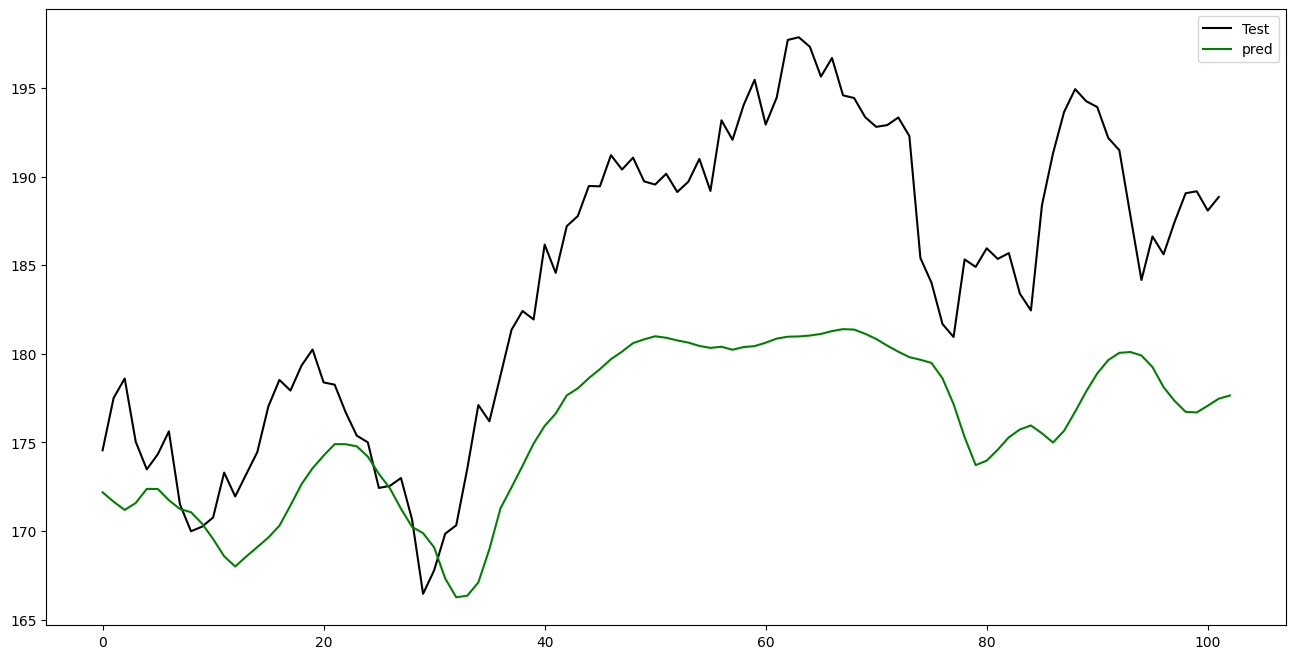

In [10]:

plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()

# save the plot
output_file = f'/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/outputs/{symbol}_plot.png'
plt.savefig(output_file)

In [ ]:
import tensorflow as tf


symbols = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'LULU', 'MSFT']
data_file_path = '/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/data/atradebot.db'
dict_of_predictions = {}

for symbol in symbols[0:1]:

    data_frame = load_data(data_file_path, symbol).drop(['id'], axis=1)
    print(data_frame.head(10))

    symbol = data_frame['symbol'].unique()[0]
    # Preprocess the data
    data_set_scaled, features, target = preprocess_data(data_frame)
    backcandles = 30
    # Prepare the input for LSTM
    X, y = prepare_lstm_input(data_set_scaled, backcandles)

    # Split the data into training and testing
    splitlimit = int(0.8*len(X))
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]

    print(f'X_train shape: {X_train.shape}'
          f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}'
          f'y_test shape: {y_test.shape}')
    
    print(type(X_train), type(y_train), type(X_test), type(y_test))

    lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
    inputs = LSTM(150, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)
    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mse')

    model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

    y_pred = model.predict(X_test)
    #y_pred=np.where(y_pred > 0.43, 1,0)
    for i in range(10):
        print(y_pred[i], y_test[i])

    tf.keras.backend.clear_session()


    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'black', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.legend()

    # save the plot
    output_file = f'/Users/anujthakkar/Documents/Purdue/Projects/wisebucks.ai/LSTM/outputs/{symbol}_plot.png'
    plt.savefig(output_file)

    
